In [1]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=fdf5f14c3ad5bf4e7f8863d23bb78853015145723af04156a85f1219967b5995
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

print(spark.sparkContext)
print("Spark App Name: " + spark.sparkContext.appName)


<SparkContext master=local[*] appName=pyspark-shell>
Spark App Name: pyspark-shell


In [3]:
# Load dataset (assuming CSV format for illustration)
df = spark.read.csv("BostonHousing.csv", header=True, inferSchema=True)
df.show()


+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575| 65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421| 78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185| 61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998| 45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147| 54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
|0.02985| 0.0| 2.18|   0|0.458| 6.43| 58.7|6.0622|  3|222|   18.7|394.12| 5.21|28.7|
|0.08829|12.5| 7.87|   0|0.524|6.012| 66.6|5.5605|  5|311|   15.2| 395.6|12.43|22.9|
|0.14455|12.5| 7.87|   0|0.524|6.172| 96.1|5.9505|  5|311|   15.2| 396.9|19.15|27.1|
|0.21124|12.5| 7.87|   0|0.524|5.631|100.0|6.0821|  5|311|   15.2

**Data Preparation**

In [4]:
from pyspark.sql.functions import col, sum as _sum

In [5]:
df.describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|              crim|                zn|             indus|              chas|                nox|                rm|               age|              dis|              rad|               tax|           ptratio|                 b|             lstat|              medv|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|               506|               506|               506|               506|                506|               506|               506|              506|              

In [7]:
num_rows = df.count()
num_cols = len(df.columns)

print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

Number of rows: 506
Number of columns: 14


In [25]:
# Checking of duplicate rows
duplicates = df.groupBy(df.columns).count().filter(col("count") > 1)
print("Number of duplicate rows:", duplicates.count())

Number of duplicate rows: 0


In [8]:
na_counts = df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
na_counts.show()

+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+
|crim| zn|indus|chas|nox| rm|age|dis|rad|tax|ptratio|  b|lstat|medv|
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+
|   0|  0|    0|   0|  0|  0|  0|  0|  0|  0|      0|  0|    0|   0|
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+



In [9]:
df.dtypes

[('crim', 'double'),
 ('zn', 'double'),
 ('indus', 'double'),
 ('chas', 'int'),
 ('nox', 'double'),
 ('rm', 'double'),
 ('age', 'double'),
 ('dis', 'double'),
 ('rad', 'int'),
 ('tax', 'int'),
 ('ptratio', 'double'),
 ('b', 'double'),
 ('lstat', 'double'),
 ('medv', 'double')]

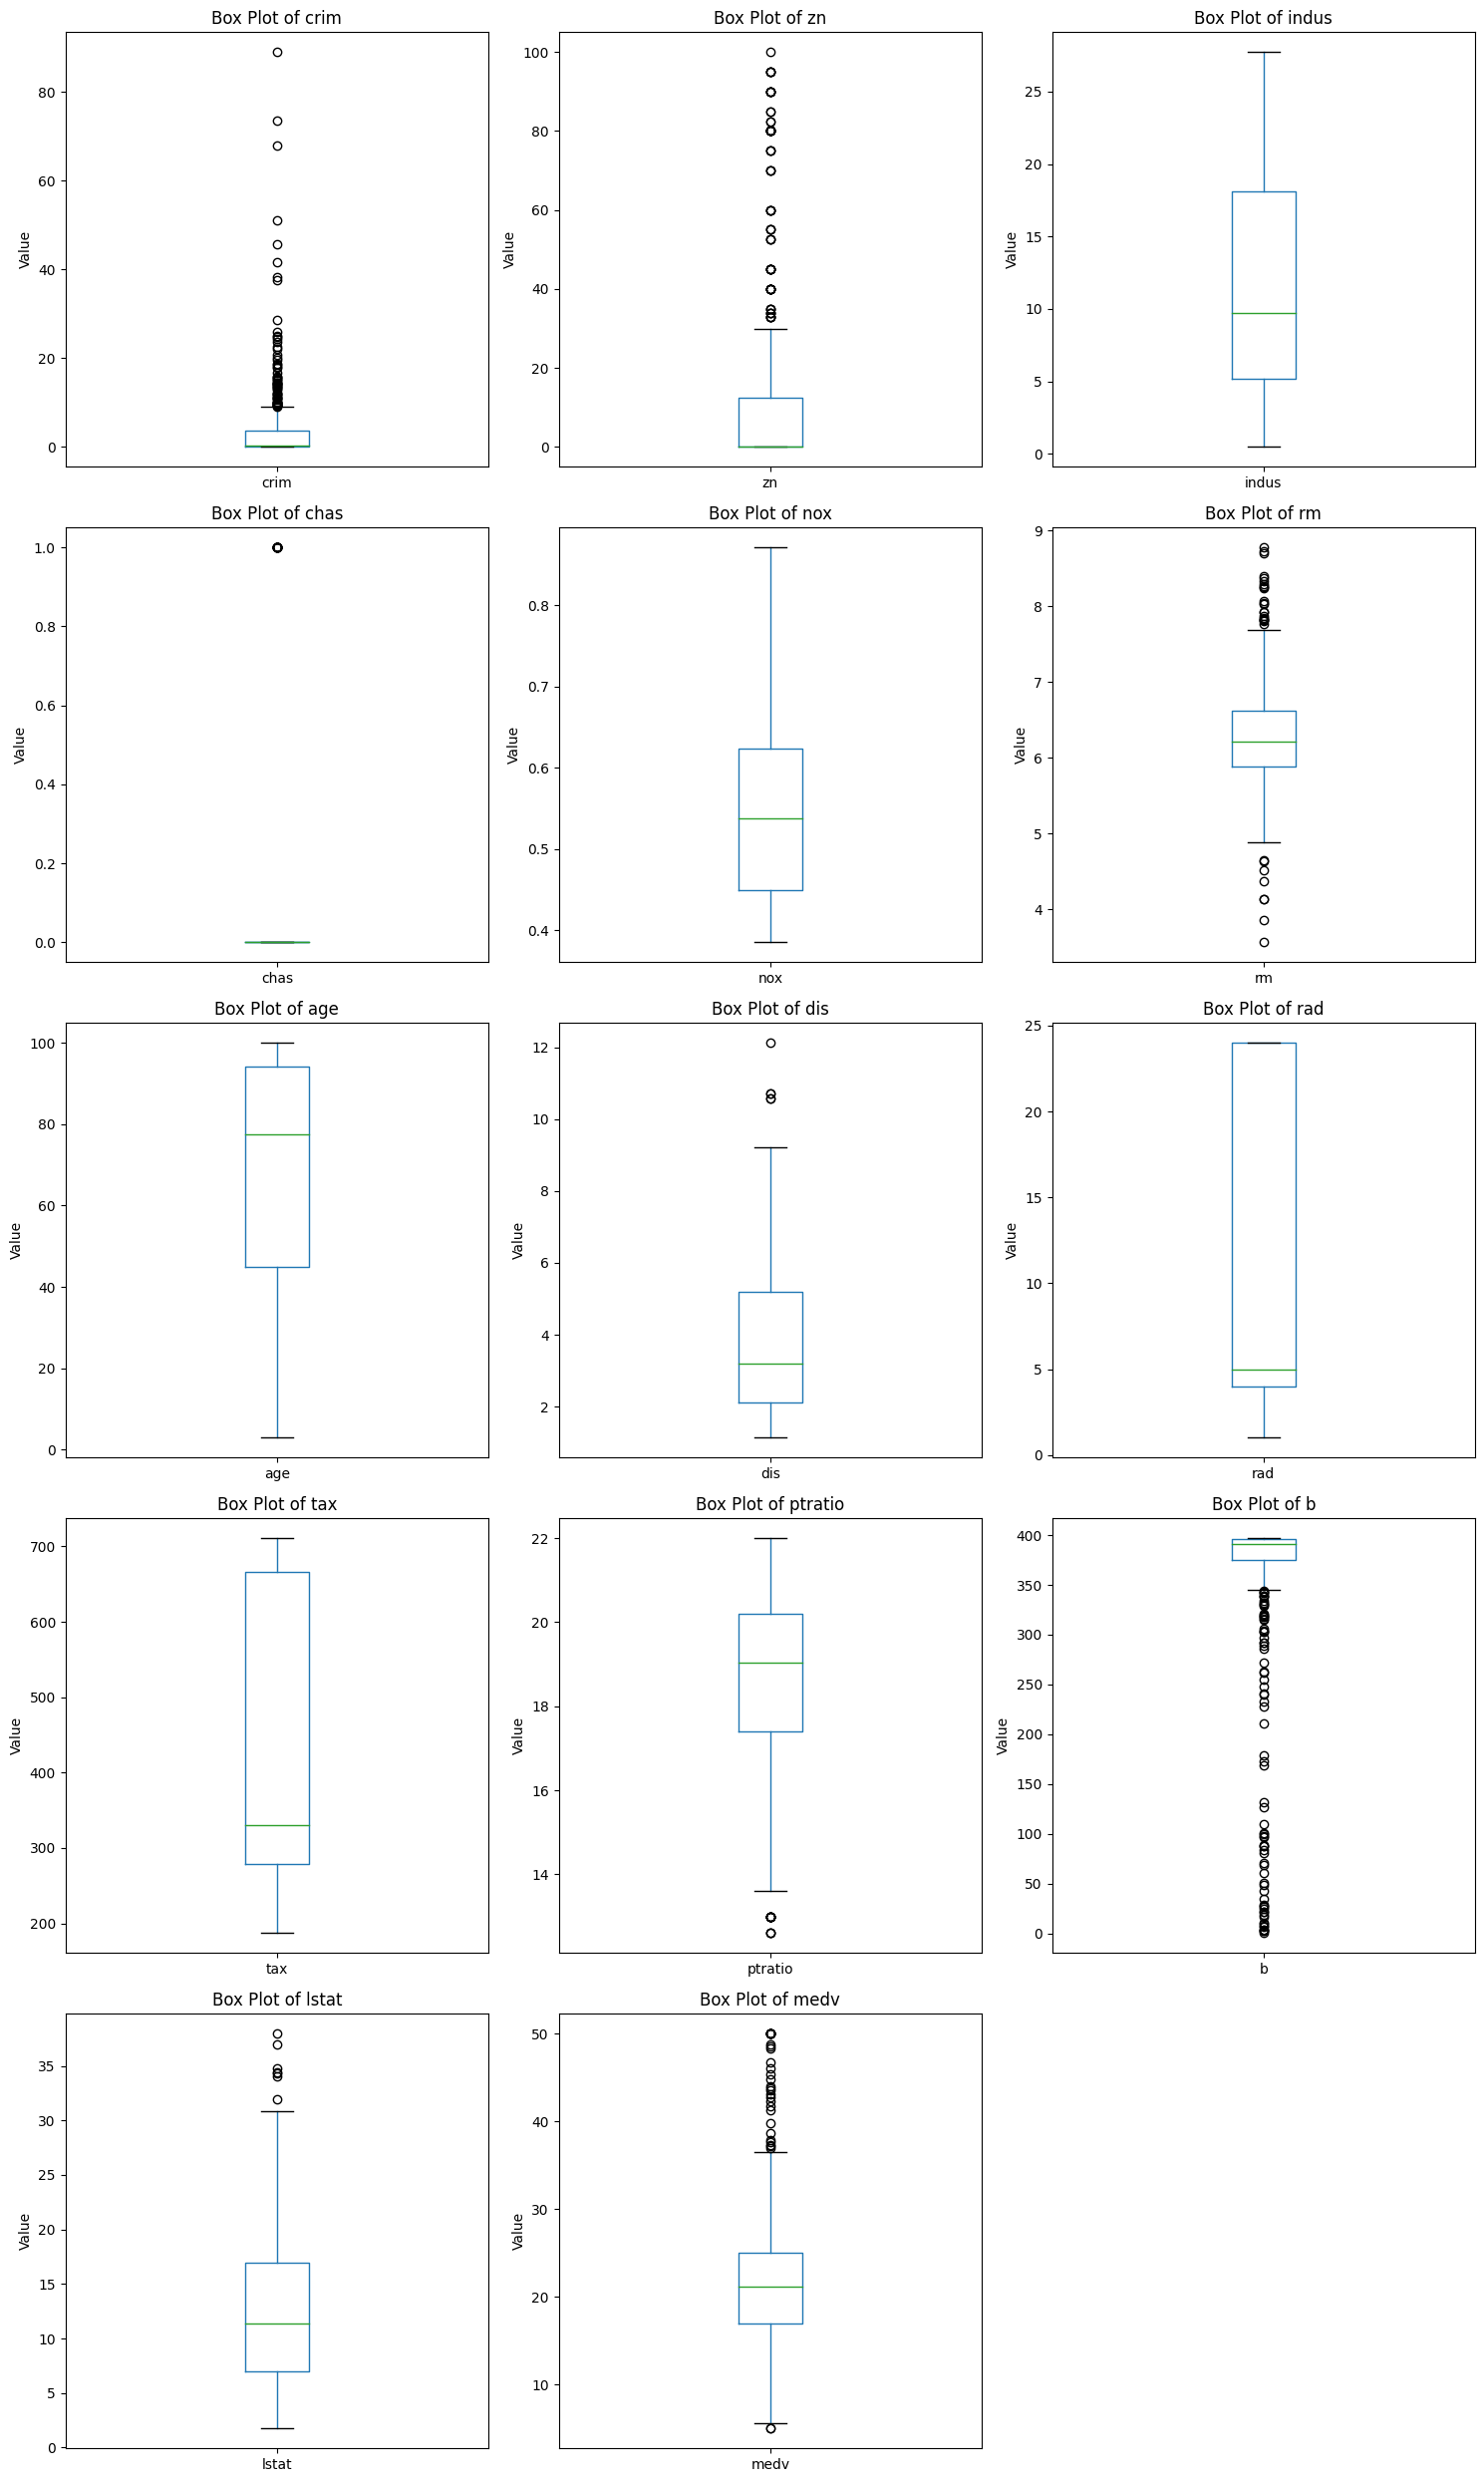

In [29]:
import math
import pandas as pd
import matplotlib.pyplot as plt

convert_to_pd = df.toPandas()
num_cols = 3
numerical_cols = convert_to_pd.select_dtypes(include='number').columns.tolist()
num_rows = math.ceil(len(numerical_cols) / num_cols)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 5))

axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    convert_to_pd.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}')
    axes[i].set_ylabel('Value')
    axes[i].grid(False)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.show()


**Understanding the variables of interest**

In [10]:
# Unique values in rm coloumn
df.select("rm").distinct().show()

+-----+
|   rm|
+-----+
|6.245|
|5.879|
|5.942|
|6.852|
|6.749|
|6.014|
|5.987|
|5.608|
|6.009|
|6.794|
| 4.88|
|5.983|
| 7.42|
|6.031|
|6.678|
| 6.43|
|6.826|
|5.536|
|6.538|
|5.456|
+-----+
only showing top 20 rows



In [11]:
# Unique values in rm coloumn
df.select("rm").distinct().show()

+-----+
|   rm|
+-----+
|6.245|
|5.879|
|5.942|
|6.852|
|6.749|
|6.014|
|5.987|
|5.608|
|6.009|
|6.794|
| 4.88|
|5.983|
| 7.42|
|6.031|
|6.678|
| 6.43|
|6.826|
|5.536|
|6.538|
|5.456|
+-----+
only showing top 20 rows



In [33]:
from pyspark.sql.functions import col, when, count, mean, min, max

# Binning based on "RM" column
df = df.withColumn(
    "RM_bin",
    when(col("rm") < 4, "Below 4")
    .when((col("rm") >= 4) & (col("rm") < 5), "4-5")
    .when((col("rm") >= 5) & (col("rm") < 6), "5-6")
    .when((col("rm") >= 6) & (col("rm") < 7), "6-7")
    .when((col("rm") >= 7) & (col("rm") < 8), "7-8")
    .otherwise("8 and above")
)

In [36]:
stats = df.groupBy("RM_bin").agg(
    count("*").alias("count"),
    mean("medv").alias("mean_medv"),
    min("medv").alias("min_medv"),
    max("medv").alias("max_medv")
)
stats.show()

+-----------+-----+------------------+--------+--------+
|     RM_bin|count|         mean_medv|min_medv|max_medv|
+-----------+-----+------------------+--------+--------+
|8 and above|   13|              44.2|    21.9|    50.0|
|        7-8|   51|36.917647058823526|    15.0|    50.0|
|    Below 4|    2|              25.3|    23.1|    27.5|
|        4-5|   13|16.023076923076925|     7.0|    50.0|
|        5-6|  158|17.487341772151893|     5.0|    50.0|
|        6-7|  269| 22.01598513011151|     7.2|    50.0|
+-----------+-----+------------------+--------+--------+



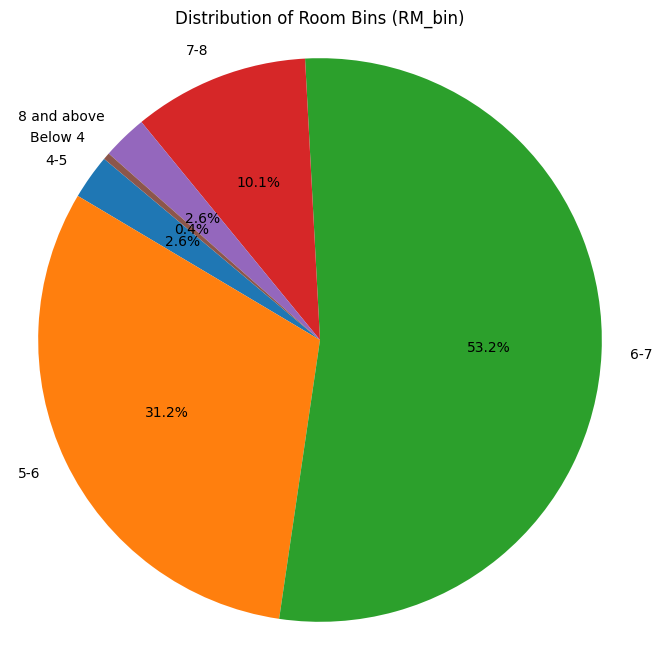

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

rm_counts = df.groupBy("RM_bin").count().orderBy("RM_bin")


rm_counts_pd = rm_counts.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(rm_counts_pd["count"], labels=rm_counts_pd["RM_bin"], autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Room Bins (RM_bin)")
plt.axis('equal')
plt.show()


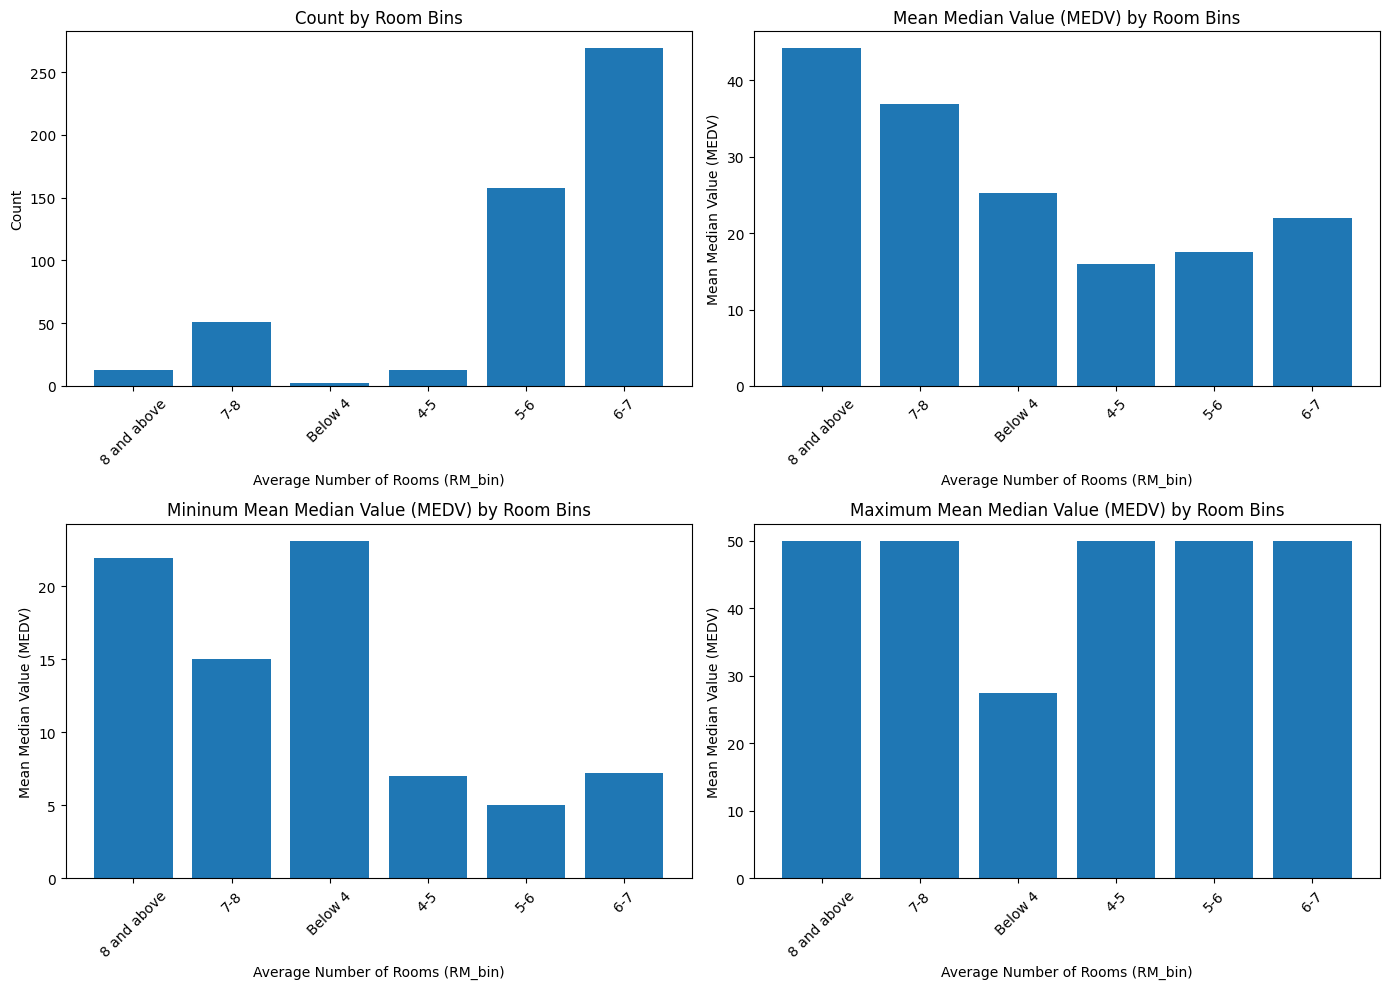

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

stats_pd = stats.toPandas()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

axes[0, 0].bar(stats_pd["RM_bin"], stats_pd["count"])
axes[0, 0].set_xlabel("Average Number of Rooms (RM_bin)")
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_title("Count by Room Bins")
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].bar(stats_pd["RM_bin"], stats_pd["mean_medv"], capsize=5)
axes[0, 1].set_xlabel("Average Number of Rooms (RM_bin)")
axes[0, 1].set_ylabel("Mean Median Value (MEDV)")
axes[0, 1].set_title("Mean Median Value (MEDV) by Room Bins")
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].bar(stats_pd["RM_bin"], stats_pd["min_medv"])
axes[1, 0].set_xlabel("Average Number of Rooms (RM_bin)")
axes[1, 0].set_ylabel("Mean Median Value (MEDV)")
axes[1, 0].set_title("Mininum Mean Median Value (MEDV) by Room Bins")
axes[1, 0].tick_params(axis='x', rotation=45)

axes[1, 1].bar(stats_pd["RM_bin"], stats_pd["max_medv"])
axes[1, 1].set_xlabel("Average Number of Rooms (RM_bin)")
axes[1, 1].set_ylabel("Mean Median Value (MEDV)")
axes[1, 1].set_title("Maximum Mean Median Value (MEDV) by Room Bins")
axes[1, 1].tick_params(axis='x', rotation=45)


plt.tight_layout()

plt.show()


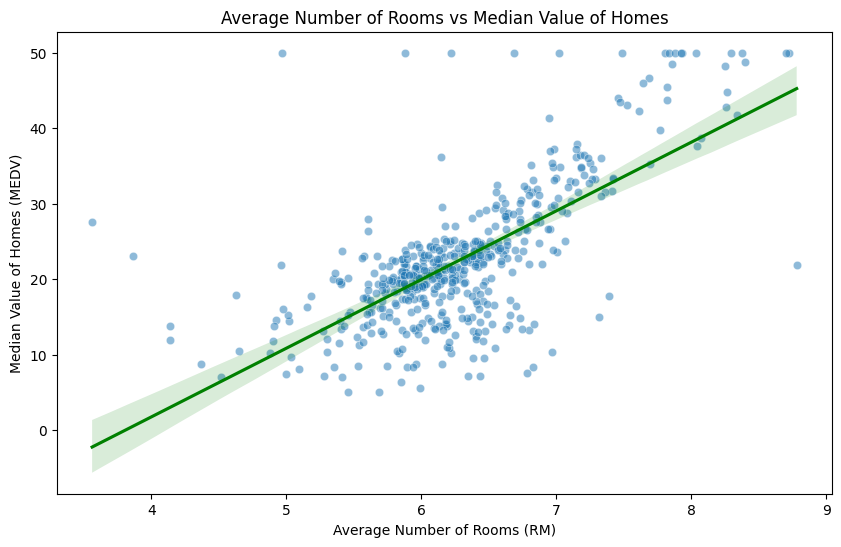

In [40]:

df_pd = df.select("rm", "medv").toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pd, x="rm", y="medv", alpha=0.5)
sns.regplot(data=df_pd, x="rm", y="medv", scatter=False, color='green')
plt.title("Average Number of Rooms vs Median Value of Homes")
plt.xlabel("Average Number of Rooms (RM)")
plt.ylabel("Median Value of Homes (MEDV)")
plt.show()


**Additional Visualisations**

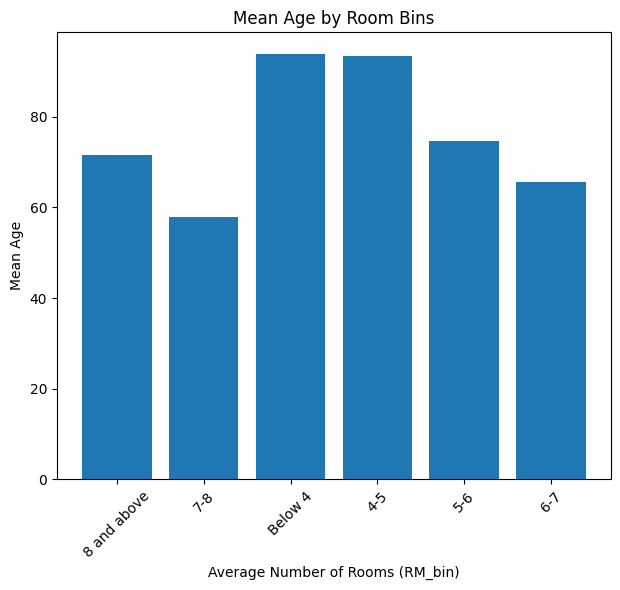

In [41]:

age_statistics = df.groupBy("RM_bin").agg(
    mean("age").alias("mean_age"),
)


age_statistics_pd = age_statistics.toPandas()


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.bar(age_statistics_pd["RM_bin"], age_statistics_pd["mean_age"])
plt.xlabel("Average Number of Rooms (RM_bin)")
plt.ylabel("Mean Age")
plt.title("Mean Age by Room Bins")
plt.xticks(rotation=45)


plt.tight_layout()


plt.show()


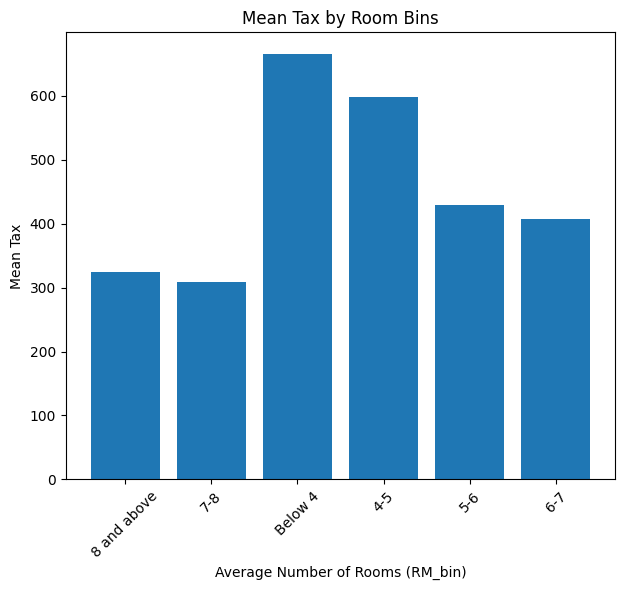

In [42]:

tax_statistics = df.groupBy("RM_bin").agg(
    mean("tax").alias("mean_tax")
)


tax_statistics_pd = tax_statistics.toPandas()


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.bar(tax_statistics_pd["RM_bin"], tax_statistics_pd["mean_tax"])
plt.xlabel("Average Number of Rooms (RM_bin)")
plt.ylabel("Mean Tax")
plt.title("Mean Tax by Room Bins")
plt.xticks(rotation=45)


plt.tight_layout()


plt.show()


In [20]:
df = df.withColumn("AGE_bin", when(col("age") <= 20, "0-20")
                                .when((col("age") > 20) & (col("age") <= 40), "20-40")
                                .when((col("age") > 40) & (col("age") <= 60), "40-60")
                                .when((col("age") > 60) & (col("age") <= 80), "60-80")
                                .otherwise("80-100"))

df.select("AGE", "AGE_bin").show()

age_bin_stats = df.groupBy("AGE_bin").agg(
    count("*").alias("count"),
)
age_bin_stats.show()

+-----+-------+
|  AGE|AGE_bin|
+-----+-------+
| 65.2|  60-80|
| 78.9|  60-80|
| 61.1|  60-80|
| 45.8|  40-60|
| 54.2|  40-60|
| 58.7|  40-60|
| 66.6|  60-80|
| 96.1| 80-100|
|100.0| 80-100|
| 85.9| 80-100|
| 94.3| 80-100|
| 82.9| 80-100|
| 39.0|  20-40|
| 61.8|  60-80|
| 84.5| 80-100|
| 56.5|  40-60|
| 29.3|  20-40|
| 81.7| 80-100|
| 36.6|  20-40|
| 69.5|  60-80|
+-----+-------+
only showing top 20 rows

+-------+-----+
|AGE_bin|count|
+-------+-----+
|  20-40|   75|
|   0-20|   34|
|  60-80|   81|
| 80-100|  240|
|  40-60|   76|
+-------+-----+



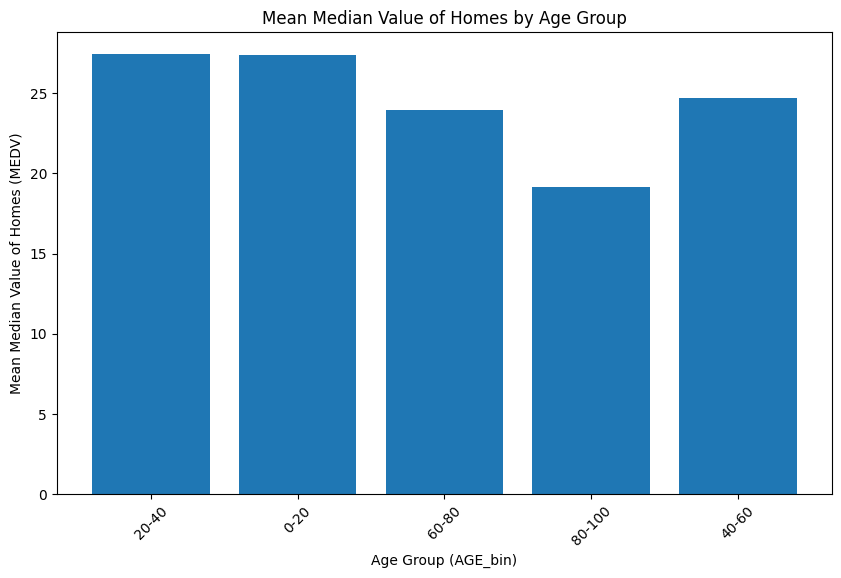

In [21]:

medv_by_age = df.groupBy("AGE_bin").agg(mean("medv").alias("mean_medv"))


medv_by_age_pd = medv_by_age.toPandas()


plt.figure(figsize=(10, 6))
plt.bar(medv_by_age_pd["AGE_bin"], medv_by_age_pd["mean_medv"])
plt.xlabel("Age Group (AGE_bin)")
plt.ylabel("Mean Median Value of Homes (MEDV)")
plt.title("Mean Median Value of Homes by Age Group")
plt.xticks(rotation=45)
plt.show()


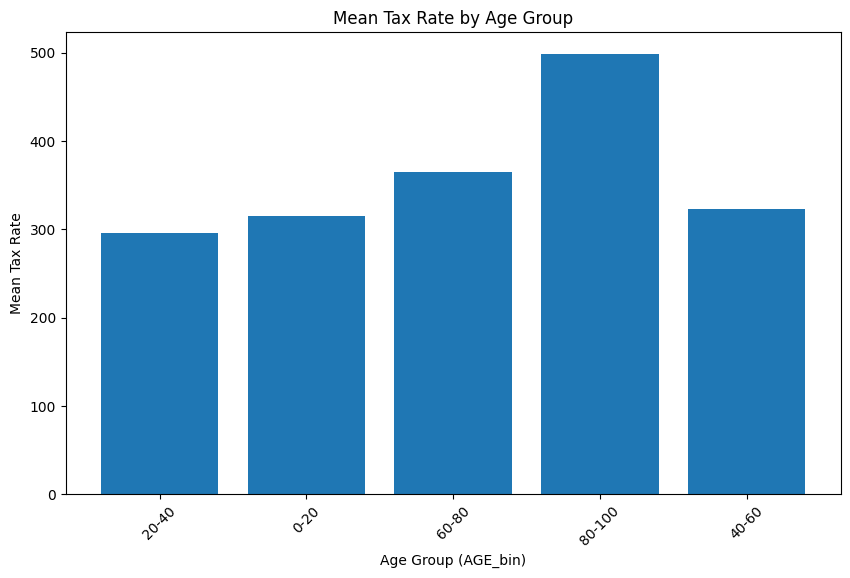

In [22]:
tax_by_age = df.groupBy("AGE_bin").agg(mean("tax").alias("mean_tax"))

tax_by_age_pd = tax_by_age.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(tax_by_age_pd["AGE_bin"], tax_by_age_pd["mean_tax"])
plt.xlabel("Age Group (AGE_bin)")
plt.ylabel("Mean Tax Rate")
plt.title("Mean Tax Rate by Age Group")
plt.xticks(rotation=45)
plt.show()


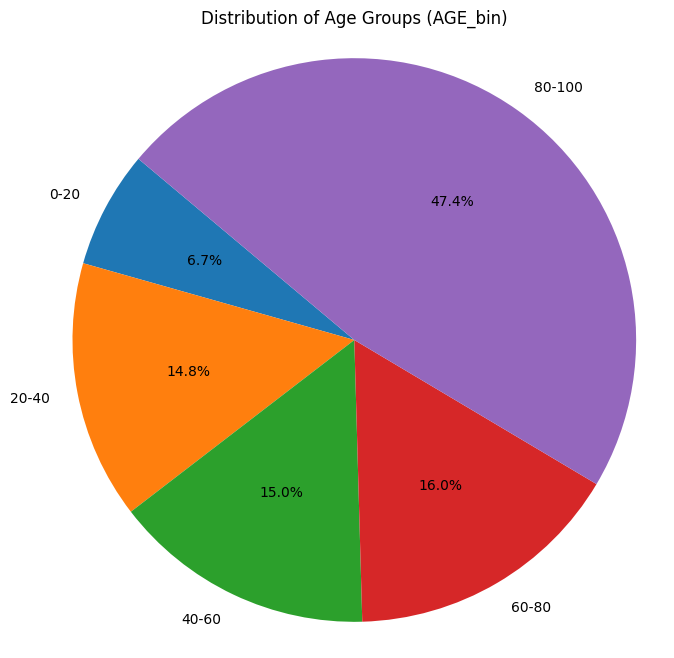

In [23]:
age_counts = df.groupBy("AGE_bin").count().orderBy("AGE_bin")

age_counts_pd = age_counts.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(age_counts_pd["count"], labels=age_counts_pd["AGE_bin"], autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Age Groups (AGE_bin)")
plt.axis('equal')
plt.show()

In [43]:
# end session
spark.stop()